In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import math
# Any results you write to the current directory are saved as output.

/home/tannmay/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tannmay/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

In [3]:
data = pd.read_csv("Training_dataset_Original.csv")
test = pd.read_csv("Leaderboard_dataset.csv")

/home/tannmay/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.columns.values

array(['application_key', 'mvar1', 'mvar2', 'mvar3', 'mvar4', 'mvar5',
       'mvar6', 'mvar7', 'mvar8', 'mvar9', 'mvar10', 'mvar11', 'mvar12',
       'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17', 'mvar18',
       'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30',
       'mvar31', 'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36',
       'mvar37', 'mvar38', 'mvar39', 'mvar40', 'mvar41', 'mvar42',
       'mvar43', 'mvar44', 'mvar45', 'mvar46', 'mvar47', 'default_ind'],
      dtype=object)

In [5]:
data.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47,default_ind
0,230032,1696,1.6541,0.000,0.0,0.0,0,6015,322,40369,...,1,73.78,82.547,0.08696,10,0.63899,na,0,C,0
1,230033,1846,0.8095,0.000,0.0,0.0,102,7532,3171,18234,...,0,99.129,missing,0,13,0.63836,na,na,L,1
2,230034,1745,0.4001,0.000,0.0,0.0,missing,2536,missing,missing,...,0,missing,29.29,0,1,1.00000,na,0,C,1
3,230035,1739,0.2193,0.000,0.0,0.0,1982,26440,4955,20316,...,0,96.272,missing,0.15385,3,0.53241,0,0,L,0
4,230036,1787,0.0118,0.225,0.0,0.0,5451,5494,5494,7987,...,0,115.019,missing,0,1,0.92665,na,na,L,0


In [6]:

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')



In [7]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['default_ind', 'application_key']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['default_ind'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['default_ind'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt', 
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'learning_rate': 0.0128,
        'n_estimators': 409,
        'num_leaves': 250,
        'max_depth': 25,
        'max_bin': 69,
        'bagging_fraction': 0.7,
        'feature_fraction' :0.7,
        'verbose': -1,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [8]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [9]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,mvar1,128404.592382,3735,0.974505
1,mvar2,122228.154959,11183,0.974505
2,mvar3,51958.502798,5835,0.974505
3,mvar4,16444.544348,2463,0.974505
4,mvar5,10759.027563,1689,0.974505


In [10]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)



Done with   80 of   80 (Spent  45.4 min)

In [11]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,mvar1,76477.975228,2762,0.973371,1
1,mvar2,58083.821481,10314,0.973371,1
2,mvar3,27250.881877,4976,0.973371,1
3,mvar4,8285.588285,1482,0.973371,1
4,mvar5,5585.544130,997,0.973371,1


In [12]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

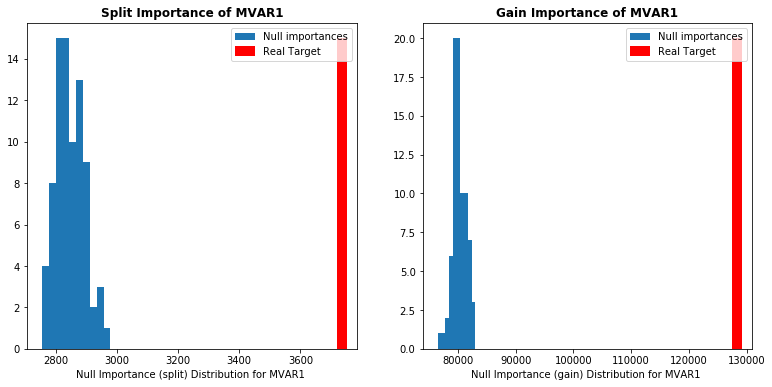

In [13]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='mvar1')

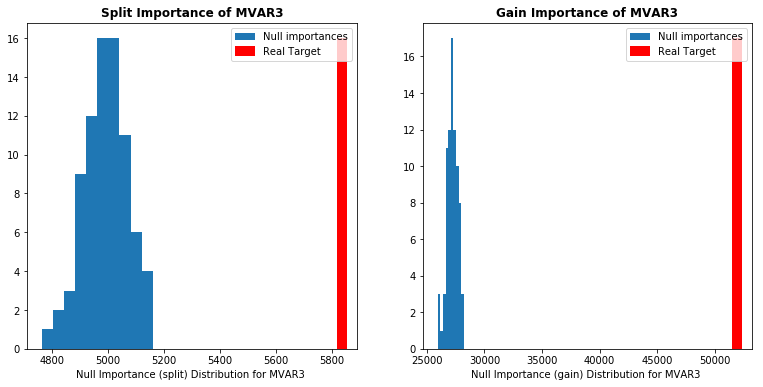

In [14]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='mvar3')

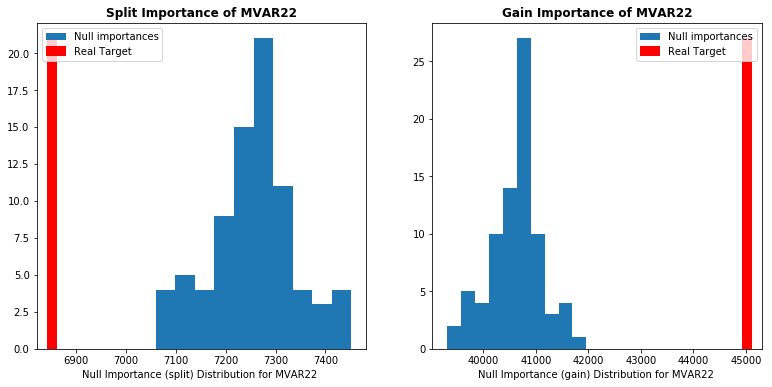

In [15]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='mvar22')

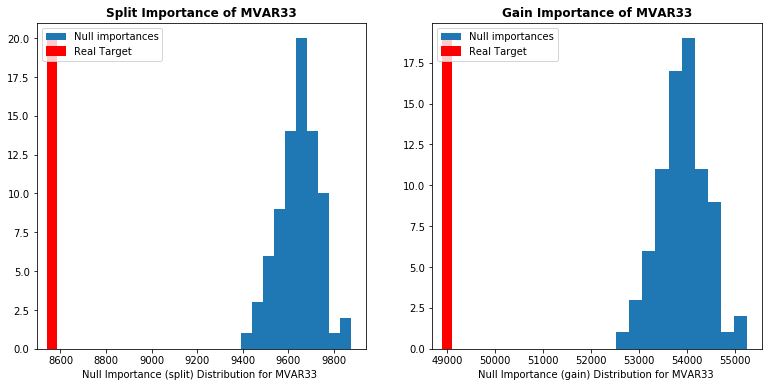

In [16]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='mvar33')

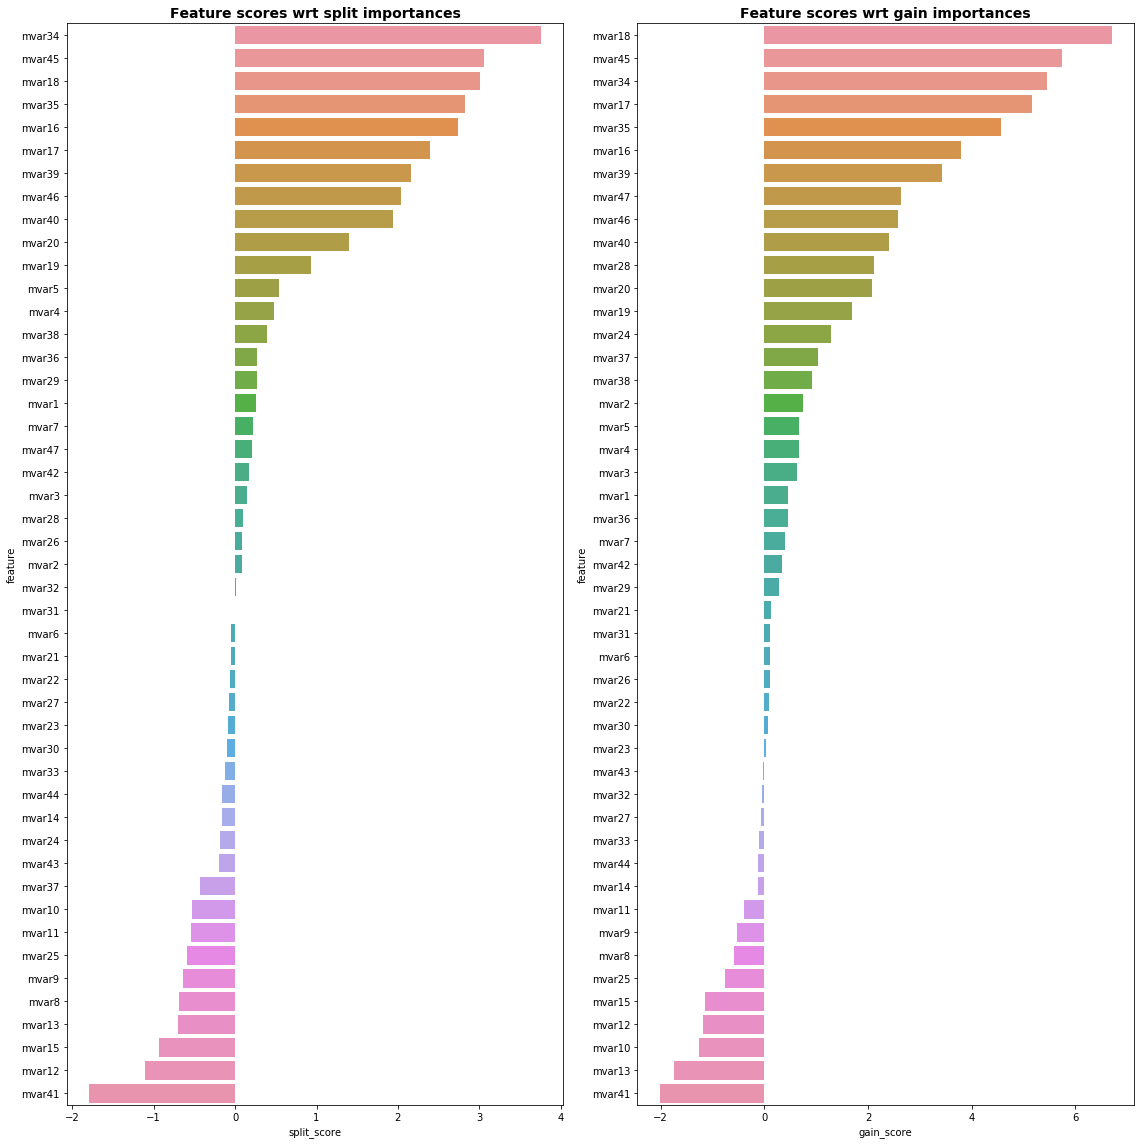

In [17]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [18]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')



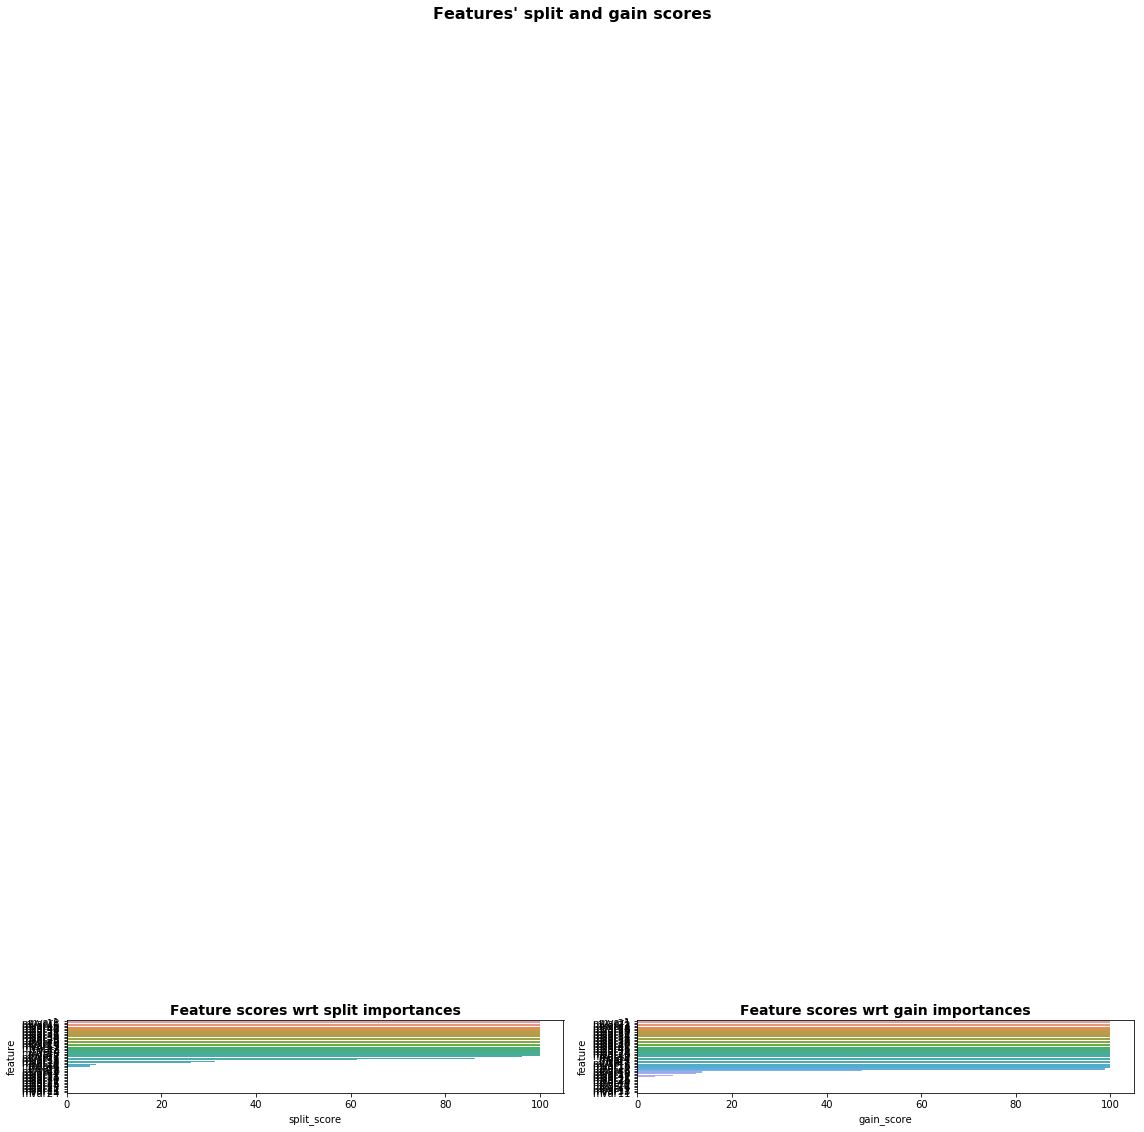

In [19]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.1)

In [20]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt', 
            'subsample': 0.623,
            'colsample_bytree': 0.7,
            'learning_rate': 0.0128,
            'n_estimators': 409,
            'num_leaves': 250,
            'max_depth': 25,
            'max_bin': 69,
            'bagging_fraction': 0.7,
            'feature_fraction' :0.7,
            'verbose': -1,
            'seed': 17,
            'bagging_freq': 1,
            'n_jobs': 4
        }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]



In [21]:
# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['default_ind'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['default_ind'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0


KeyError: 'auc-mean'